In [83]:
import numpy as np
import os
import statistics 
from tqdm.notebook import tqdm
import torch
from torch.optim import Adam
import matplotlib.pyplot as plt

In [84]:
# Usamos cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [85]:
mean = np.load('Res/x_mean.npy')
maxi = np.load('Res/x_max.npy')
mini = np.load('Res/x_min.npy')

In [86]:
import librosa

In [80]:
librosa.time_to_frames(8.747901,sr=44100)

753

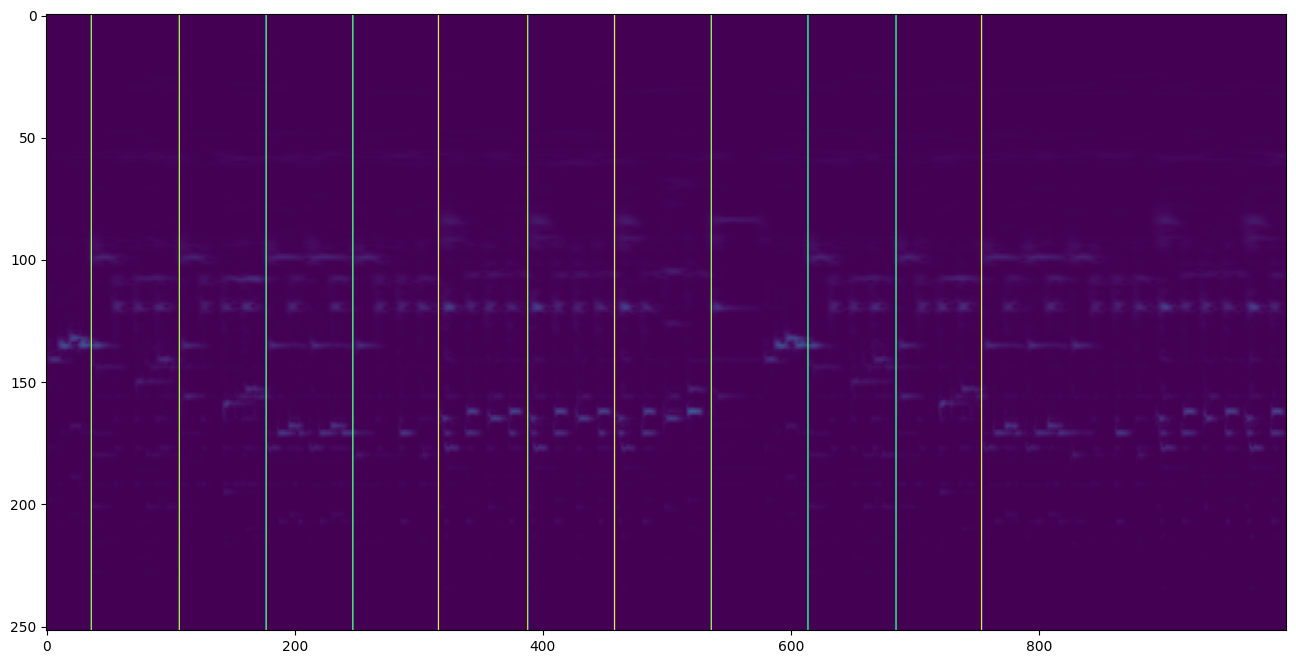

In [82]:
x = np.load('Test np/x_MAPS_MUS-mz_331_3_ENSTDkCl_A_M.npy')
x[35+1]=10
x[106+1]=10
x[176+1]=10
x[246+1]=10
x[315+1]=10
x[387+1]=10
x[457+1]=10
x[535+1]=10
x[613+1]=10
x[684+1]=10
x[753+1]=10
plt.figure(figsize=(16, 8))
plt.imshow(x[:1000].T, aspect="auto")

In [87]:
l = os.listdir('Train np')
lis=[]
for arch in l:
    if arch.startswith('x_'):
        lis.append(arch)

In [88]:
X_train=[]
Y_train=[]
for mus in tqdm(lis):
    x = np.load('Train np/'+mus)
    y = np.load('Train np/'+mus.replace('x_','y_'))
    x = np.nan_to_num((x - mini)/(maxi-mini)-mean)
    x = np.pad(x, ((3,3), (0,0)), 'constant', constant_values = 0)
    for i in range(x.shape[0]-6):
        X_train.append(torch.from_numpy(x[i:i+7]).float())
        Y_train.append(torch.from_numpy(y[i]).float())

  0%|          | 0/210 [00:00<?, ?it/s]

In [89]:
l = os.listdir('Test np')
lis=[]
for arch in l:
    if arch.startswith('x_'):
        lis.append(arch)

In [90]:
X_test=[]
Y_test=[]
for mus in tqdm(lis):
    x = np.load('Test np/'+mus)
    y = np.load('Test np/'+mus.replace('x_','y_'))
    x = np.nan_to_num((x - mini)/(maxi-mini)-mean)
    x = np.pad(x, ((3,3), (0,0)), 'constant', constant_values = 0)
    for i in range(x.shape[0]-6):
        X_test.append(torch.from_numpy(x[i:i+7]).float())
        Y_test.append(torch.from_numpy(y[i]).float())

  0%|          | 0/60 [00:00<?, ?it/s]

In [91]:
from torch.utils.data import Dataset

class TrainData(Dataset):
    def __init__(self):
        self.samples = X_train
        self.labels = Y_train

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]
    
class TestData(Dataset):
    def __init__(self):
        self.samples = X_test
        self.labels = Y_test

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

In [92]:
Traindata = TrainData()
Testdata = TestData()

In [93]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=Traindata, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=Testdata, batch_size=batch_size, shuffle=True)

In [94]:
import torch.nn as nn

In [95]:
def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    best_valid_loss = float('inf')
    Tl=[]
    Vl=[]
    Va=[]
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            X = X.to(device)
            Y = Y.to(device)
            Y_preds = model(X)
            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(i)
        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        Tl.append(torch.tensor(losses).mean())
        vl = CalcValLossAndAccuracy(model, loss_fn, val_loader)
        if vl< best_valid_loss:
            best_valid_loss = vl
            torch.save(model.state_dict(), './best-val-Model.pt')
        Vl.append(vl)
    plt.plot(Tl, label = "Loss Entrenamiento")
    plt.plot(Vl, label= "Loss Validacion")
    plt.legend()
    plt.show()

In [96]:
#Calcular perdida y accuracy de test
def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        losses = []
        for X, Y in tqdm(val_loader):
            X = X.to(device)
            Y = Y.to(device)
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())
        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        return(torch.tensor(losses).mean())

In [97]:
class create_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=50, kernel_size=(5,25), padding=0)
        self.Norb1 = nn.BatchNorm2d(50)
        self.pool = nn.MaxPool2d(kernel_size=(1,3), stride=1)
        self.conv2 = nn.Conv2d(in_channels=50, out_channels=50, kernel_size=(3,5), padding=0)
        self.Norb2 =  nn.BatchNorm2d(50)
        self.linear1 = nn.Linear(11000, 1000)
        self.linear2 = nn.Linear(1000, 200)
        self.linear3 = nn.Linear(200, 88)
        self.Drop   = nn.Dropout(0.2)
        self.ReLU   = nn.ReLU()
        self.Sig     = nn.Sigmoid()
        
        
    def forward(self, x): 
        x = x.reshape(-1, 7,252, 1)
        x = x.permute(0, 3, 1, 2)
        x = self.Drop(self.ReLU(self.Norb1(self.conv1(x))))
        x = self.pool(x)
        x = self.Drop(self.ReLU(self.Norb2(self.conv2(x))))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.Drop(self.ReLU(self.linear1(x)))
        x = self.Drop(self.ReLU(self.linear2(x)))
        x = self.Sig(self.linear3(x))
        return x

  0%|          | 0/16597 [00:00<?, ?it/s]

1
Train Loss : 0.017


  0%|          | 0/5271 [00:00<?, ?it/s]

Valid Loss : 0.026


  0%|          | 0/16597 [00:00<?, ?it/s]

2
Train Loss : 0.012


  0%|          | 0/5271 [00:00<?, ?it/s]

Valid Loss : 0.025


  0%|          | 0/16597 [00:00<?, ?it/s]

3
Train Loss : 0.011


  0%|          | 0/5271 [00:00<?, ?it/s]

Valid Loss : 0.025


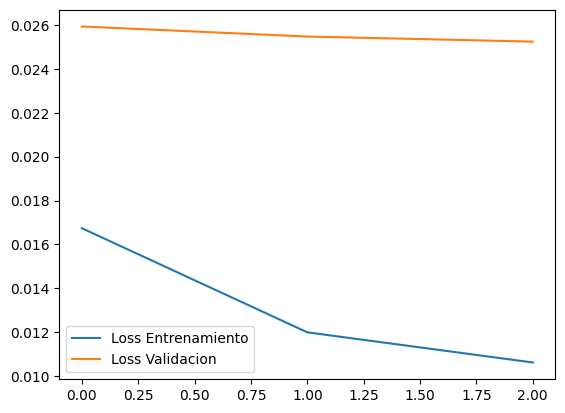

In [98]:
epochs = 3
learning_rate = 1e-4

loss_fn = nn.MSELoss()
classifier = create_model()
classifier.to(device)
optimizer = Adam(classifier.parameters(), lr=learning_rate)

TrainModel(classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

  0%|          | 0/16597 [00:00<?, ?it/s]

1
Train Loss : 0.010


  0%|          | 0/5271 [00:00<?, ?it/s]

Valid Loss : 0.024


  0%|          | 0/16597 [00:00<?, ?it/s]

2
Train Loss : 0.009


  0%|          | 0/5271 [00:00<?, ?it/s]

Valid Loss : 0.025


  0%|          | 0/16597 [00:00<?, ?it/s]

3
Train Loss : 0.009


  0%|          | 0/5271 [00:00<?, ?it/s]

Valid Loss : 0.025


  0%|          | 0/16597 [00:00<?, ?it/s]

4
Train Loss : 0.008


  0%|          | 0/5271 [00:00<?, ?it/s]

Valid Loss : 0.025


  0%|          | 0/16597 [00:00<?, ?it/s]

5
Train Loss : 0.008


  0%|          | 0/5271 [00:00<?, ?it/s]

Valid Loss : 0.025


  0%|          | 0/16597 [00:00<?, ?it/s]

6
Train Loss : 0.008


  0%|          | 0/5271 [00:00<?, ?it/s]

Valid Loss : 0.025


  0%|          | 0/16597 [00:00<?, ?it/s]

7
Train Loss : 0.007


  0%|          | 0/5271 [00:00<?, ?it/s]

Valid Loss : 0.025


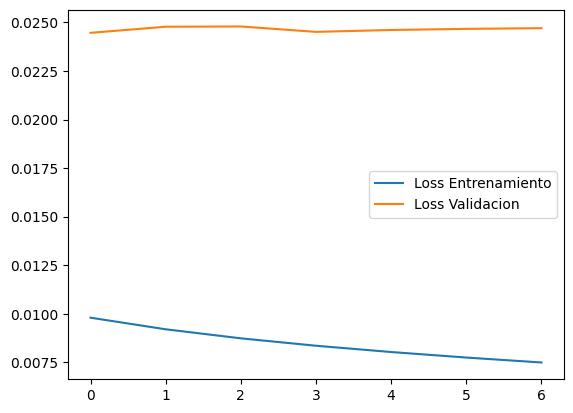

In [15]:
#Leva 3
epochs = 7
learning_rate = 1e-4
loss_fn = nn.MSELoss()
classifier = create_model().to(device)
classifier.load_state_dict(torch.load('Res/best-val-Model.pt'))
classifier.to(device)
optimizer = Adam(classifier.parameters(), lr=learning_rate)

TrainModel(classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

In [106]:
#Se carga el modelo ya entrenado
model = create_model().to('cpu')
model.load_state_dict(torch.load('Res/best-val-Model.pt'))
model.eval()

create_model(
  (conv1): Conv2d(1, 50, kernel_size=(5, 25), stride=(1, 1))
  (Norb1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(1, 3), stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 50, kernel_size=(3, 5), stride=(1, 1))
  (Norb2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=11000, out_features=1000, bias=True)
  (linear2): Linear(in_features=1000, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=88, bias=True)
  (Drop): Dropout(p=0.2, inplace=False)
  (ReLU): ReLU()
  (Sig): Sigmoid()
)

In [100]:
def evalu(model, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds = [],[]
        for X, Y in tqdm(val_loader):
            X = X.to(device)
            preds = model(X).to('cpu')

            Y_shuffled.append(Y.numpy())
            Y_preds.append(preds.numpy())
    return Y_shuffled, Y_preds

In [101]:
Y_s, Y_p = evalu(model, test_loader)

  0%|          | 0/5271 [00:00<?, ?it/s]

In [102]:
yhat = Y_p[0]
y_test = Y_s[0]
for i in tqdm(range(1,len(Y_s))):
    yhat = np.concatenate((yhat,Y_p[i]),axis=0)
    y_test = np.concatenate((y_test,Y_s[i]),axis=0)
yhat = 1.0 * ( yhat > 0.5)

  0%|          | 0/5270 [00:00<?, ?it/s]

In [103]:
TP = np.count_nonzero(np.logical_and( yhat == 1, y_test == 1 ))
FN = np.count_nonzero(np.logical_and( yhat == 0, y_test == 1 ))
FP = np.count_nonzero(np.logical_and( yhat == 1, y_test == 0 ))
print (TP, FN, FP)
if (TP + FN) > 0:
    R = TP/float(TP + FN)
    P = TP/float(TP + FP)
    A = TP/float(TP + FP + FN)
    if P == 0 and R == 0:
        F = 0
    else: 
        F = 2*P*R/(P + R)
else: 
    A = 0
    F = 0
    R = 0
    P = 0

print ('\n F-measure pre-processed: ')
print (F)
print ('\n Accuracy pre-processed: ')
print (A)

3993541 1815735 1589226

 F-measure pre-processed: 
0.7011105909624814

 Accuracy pre-processed: 
0.539776971067927


In [104]:
X=[]
x = np.load('Test np/x_MAPS_MUS-mz_331_3_ENSTDkCl_A_M.npy')
x = np.nan_to_num((x - mini)/(maxi-mini)-mean)
x = np.pad(x, ((3,3), (0,0)), 'constant', constant_values = 0)
for i in range(x.shape[0]-6):
    X.append(torch.from_numpy(x[i:i+7]).float())

In [105]:
y_test = np.load('Test np/y_MAPS_MUS-mz_331_3_ENSTDkCl_A_M.npy')

In [107]:
Y = []
for k in X:
    Y.append(model(k))

In [108]:
y_hat = torch.cat(Y)
y_hat = y_hat.detach().numpy()
Y_pred = 1.0 * ( np.array(y_hat) > 0.5)

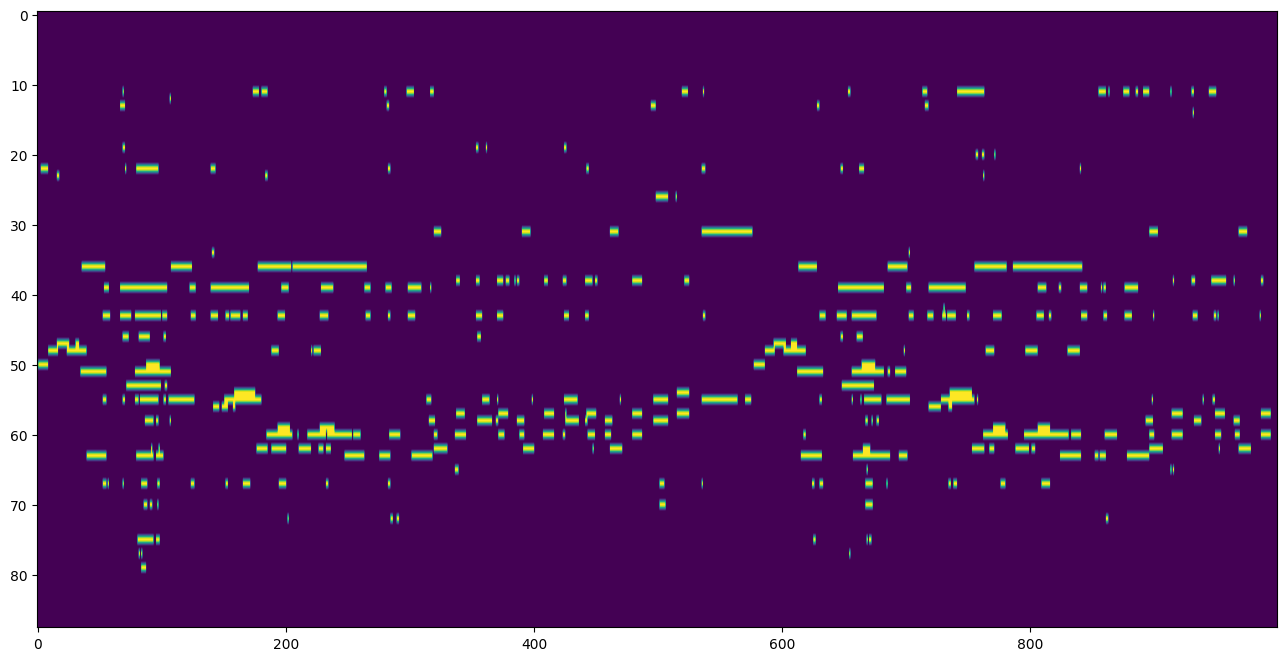

In [109]:
plt.figure(figsize=(16, 8))
plt.imshow(Y_pred[:1000].T, aspect="auto")

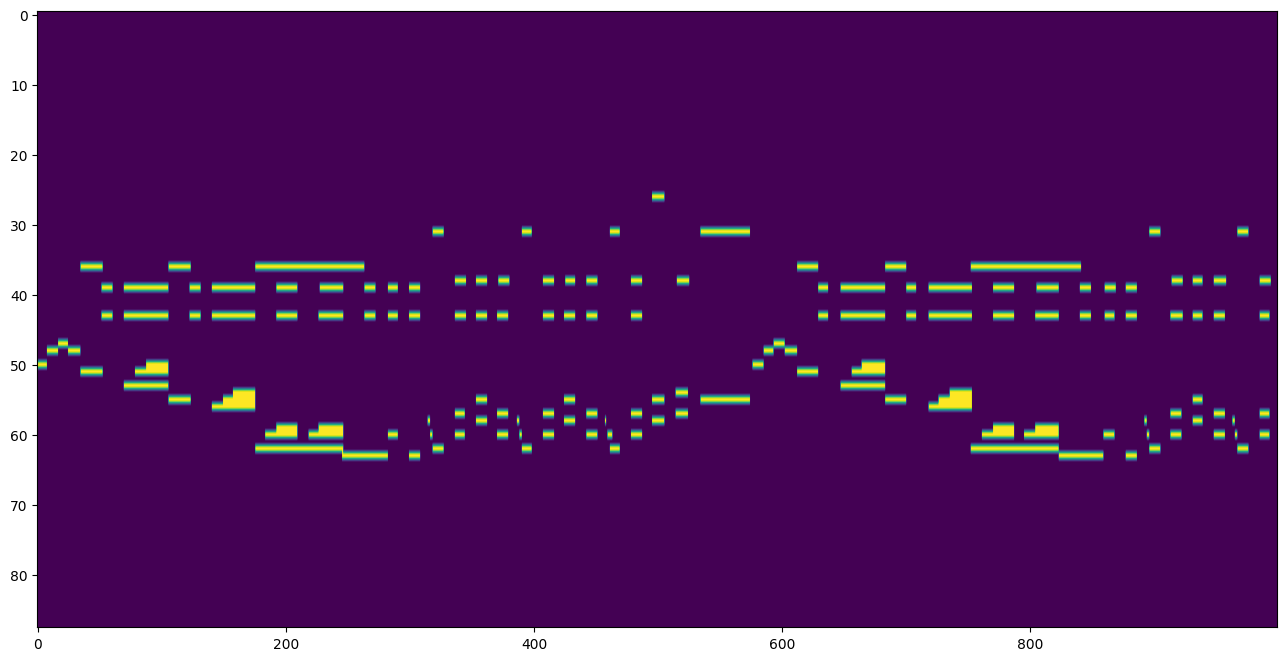

In [17]:
plt.figure(figsize=(16, 8))
plt.imshow(y_test[:1000].T, aspect="auto")

In [14]:
np.save('Res/y_hat.npy', Y_pred)